##### Imports & setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

# Feature names (without linear features):
feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std', 'cusum', 'IPR10',
                 'kurtosis', 'MPR40_5', 'MPR20_10', 'maxSlope', 'medianAbsDev', 'medianBRP10',
                 'percentAmplitude', 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

## Data preparation

### Getting data

In [10]:
# The following paths should be changed accordingly. The data can be saved in a csv from the clean_data.ipynb notebook.
positive_g = pd.read_csv('../../data/clean_data/positive_class_g.csv', index_col=0)
positive_r = pd.read_csv('../../data/clean_data/positive_class_r.csv', index_col=0)
negative_g = pd.read_csv('../../data/clean_data/negative_class_g.csv', index_col=0)
negative_r = pd.read_csv('../../data/clean_data/negative_class_r.csv', index_col=0)



# Adding labels for each class:
positive_g['class'] = 'positive'
positive_r['class'] = 'positive'
negative_g['class'] = 'negative'
negative_r['class'] = 'negative'

In [11]:
positive_g

,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,IPR10,kurtosis,linT,...,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK,objectId,anomaly_score,class
4816,13.817506,13.828649,0.195803,13.896276,0.234263,0.200000,0.346548,0.468526,3.736549,-0.012028,...,0.200000,0.418046,0.014171,0.515629,143.749041,-1.915839,0.754049,ZTF17aabdpti,-0.133778,positive
19903,13.817509,13.828649,0.195798,13.896276,0.234256,0.200000,0.346548,0.468512,3.736476,-0.012028,...,0.200000,0.418033,0.014170,0.515619,143.744461,-1.915821,0.754053,ZTF17aabdpti,-0.132313,positive
13552,13.869760,13.870895,0.063930,13.895045,0.080594,0.400000,0.402923,0.161188,-1.246543,0.001090,...,0.400000,0.109477,0.004609,0.204758,14.404587,-0.309796,0.915388,ZTF17aabdpti,-0.119457,positive
19496,13.900870,13.893656,0.048767,13.896276,0.060799,0.200000,0.329353,0.121598,0.822606,0.000070,...,0.400000,0.071118,0.003508,0.280313,14.517087,-0.979036,0.762692,ZTF17aabdpti,-0.122106,positive
18477,13.902325,13.893262,0.056184,13.918694,0.060799,0.250000,0.370289,0.121598,0.423473,-0.000262,...,0.000000,0.093537,0.004041,0.147103,19.350766,-1.179132,0.848727,ZTF17aabdpti,-0.117620,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18842,22.549217,21.128512,1.555005,22.282448,1.860645,0.500000,0.342027,3.721289,1.874512,-0.152833,...,0.500000,2.394183,0.068960,0.120376,0.043360,0.976036,0.944425,ZTF17aaajocf,-0.021572,positive
5897,22.550707,21.069446,1.315610,22.466846,2.012253,0.375000,0.236583,3.558844,-0.083084,-0.062041,...,0.000000,2.354850,0.058340,0.199931,0.050273,0.336103,0.894589,ZTF17aaajocf,-0.020418,positive
15876,22.551057,20.995273,1.503454,22.433220,1.924888,0.571429,0.375275,3.763740,-1.122533,-0.014950,...,0.285714,2.243411,0.066669,0.397411,0.040456,0.439798,0.884374,ZTF17aaajocf,-0.026530,positive
24135,22.572617,20.897052,1.276727,22.769723,2.115585,0.333333,0.246608,3.527623,0.195840,0.020095,...,0.222222,2.179198,0.056561,0.226036,0.072137,0.083722,0.935753,ZTF17aaajocf,-0.019931,positive


In [12]:
# Normalizing features:
positive_g[feature_names] = normalize(positive_g[feature_names], axis=0)
positive_r[feature_names] = normalize(positive_r[feature_names], axis=0)
negative_g[feature_names] = normalize(negative_g[feature_names], axis=0)
negative_r[feature_names] = normalize(negative_r[feature_names], axis=0)

In [13]:
positive_g

,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,IPR10,kurtosis,linT,...,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK,objectId,anomaly_score,class
4816,0.012391,0.012571,0.005356,0.012483,0.004208,0.010098,0.016927,0.005379,0.019575,-0.012028,...,0.011275,0.004913,0.006995,0.009978,0.013280,-0.025940,0.014051,ZTF17aabdpti,-0.133778,positive
19903,0.012391,0.012571,0.005355,0.012483,0.004208,0.010098,0.016926,0.005379,0.019575,-0.012028,...,0.011275,0.004913,0.006995,0.009977,0.013279,-0.025940,0.014051,ZTF17aabdpti,-0.132313,positive
13552,0.012437,0.012610,0.001749,0.012482,0.001448,0.020196,0.019680,0.001850,-0.006530,0.001090,...,0.022550,0.001287,0.002275,0.003962,0.001331,-0.004195,0.017058,ZTF17aabdpti,-0.119457,positive
19496,0.012465,0.012630,0.001334,0.012483,0.001092,0.010098,0.016087,0.001396,0.004310,0.000070,...,0.022550,0.000836,0.001732,0.005424,0.001341,-0.013256,0.014212,ZTF17aabdpti,-0.122106,positive
18477,0.012467,0.012630,0.001537,0.012504,0.001092,0.012622,0.018086,0.001396,0.002219,-0.000262,...,0.000000,0.001099,0.001995,0.002846,0.001788,-0.015965,0.015816,ZTF17aabdpti,-0.117620,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18842,0.020220,0.019207,0.042533,0.020017,0.033425,0.025244,0.016706,0.042720,0.009820,-0.152833,...,0.028187,0.028139,0.034040,0.002329,0.000004,0.013215,0.017599,ZTF17aaajocf,-0.021572,positive
5897,0.020222,0.019154,0.035985,0.020183,0.036148,0.018933,0.011555,0.040855,-0.000435,-0.062041,...,0.000000,0.027676,0.028798,0.003869,0.000005,0.004551,0.016670,ZTF17aaajocf,-0.020418,positive
15876,0.020222,0.019086,0.041123,0.020152,0.034579,0.028851,0.018330,0.043208,-0.005881,-0.014950,...,0.016107,0.026367,0.032909,0.007690,0.000004,0.005955,0.016480,ZTF17aaajocf,-0.026530,positive
24135,0.020241,0.018997,0.034921,0.020455,0.038004,0.016830,0.012045,0.040497,0.001026,0.020095,...,0.012528,0.025612,0.027920,0.004374,0.000007,0.001134,0.017437,ZTF17aaajocf,-0.019931,positive


### Organizing samples & train-test split

Ignoring the two filters, we have two main datasets:
1. The positive class, which contains alerts form known magnetic cataclysmic variable stars.
2. The negative class, which contains alerts from objects that are not in the positive class or that are unknown.

These two classes live in a ~20 dimensional feature space, and we hope that the positive class is somewhat clustered in that space. If that is the case, the nearest neighbors of positive class objects should also be of the positive class.

Since the positive class is poorly represented compared to the negative one, we first try here the nearest neighbors algorithm on a dataset composed of an equal number of alerts from the positive and negative classes. Then, the number of alerts from the negative class is increased by a factor two and then three.

**The train and test samples should contain different objects**

In [3]:
# IDs of unique objects in each class:
positive_g_Ids = np.unique(positive_g['objectId'])
positive_r_Ids = np.unique(positive_r['objectId'])
negative_g_Ids = np.unique(negative_g['objectId'])
negative_r_Ids = np.unique(negative_r['objectId'])

# Number of unique objects in each class:
print(f'There are {len(positive_g_Ids)} unique objects in the positive class (g filter).')
print(f'There are {len(positive_r_Ids)} unique objects in the positive class (r filter).')
print(f'There are {len(negative_g_Ids)} unique objects in the negative class (g filter).')
print(f'There are {len(negative_r_Ids)} unique objects in the negative class (r filter).')

There are 69 unique objects in the positive class (g filter).
There are 67 unique objects in the positive class (r filter).
There are 101035 unique objects in the negative class (g filter).
There are 93551 unique objects in the negative class (r filter).


In [4]:
np.random.seed(42)

# Splitting the positive class with 70% of objects in the train set and 30% in the test:
positive_g_Ids_train, positive_g_Ids_test = train_test_split(positive_g_Ids, train_size=.7)
positive_g_train = positive_g[positive_g['objectId'].isin(positive_g_Ids_train)]
positive_g_test = positive_g[positive_g['objectId'].isin(positive_g_Ids_test)]

# Splitting the negative class with 70% of objects in the train set and 30% in the test:
negative_g_Ids_train, negative_g_Ids_test = train_test_split(negative_g_Ids, train_size=.7)
negative_g_train = negative_g[negative_g['objectId'].isin(negative_g_Ids_train)]
negative_g_test = negative_g[negative_g['objectId'].isin(negative_g_Ids_test)]

# Sampling x alerts in the negative train set (x = nb of alerts in the positive train set):
negative_g_train_sample_indices1 = np.random.choice(negative_g_train.index, len(positive_g_train), replace=False)
negative_g_train_sample1 = negative_g_train.loc[negative_g_train_sample_indices1]

# Sampling 2x alerts in the negative train set
negative_g_train_sample_indices2 = np.random.choice(negative_g_train.index, 2*len(positive_g_train), replace=False)
negative_g_train_sample2 = negative_g_train.loc[negative_g_train_sample_indices2]

# Sampling 3x alerts in the negative train set
negative_g_train_sample_indices3 = np.random.choice(negative_g_train.index, 3*len(positive_g_train), replace=False)
negative_g_train_sample3 = negative_g_train.loc[negative_g_train_sample_indices3]

# Assembling the final train sets:
train_sample1 = pd.concat([positive_g_train, negative_g_train_sample1]).reset_index()
train_sample2 = pd.concat([positive_g_train, negative_g_train_sample2]).reset_index()
train_sample3 = pd.concat([positive_g_train, negative_g_train_sample3]).reset_index()
train_sample4 = pd.concat([positive_g_train, negative_g_train]).reset_index() # Using the whole negative class

## Finding nearest neighbors

### Wrapper

In [5]:
def NN_wrapper(train: pd.DataFrame, test: pd.DataFrame, k: int = 1) -> pd.DataFrame:
    """Wrapper for the NearestNeighbors class from scikit-learn.
    This function takes the training and testing sets and prints out the propotion of neighbors that are of the positive and negative class.

    Args:
        train (pd.DataFrame): Training set (a combination of positive and negative class objects).
        test (pd.DataFrame): Testing set (positive class objects only, and different from those of the training set).
        k (int, optional): Number of nearest neighbors to look for for each object in the test set. Defaults to 1.
    
    Returns:
        neighbors (pd.DataFrame): The neighbors of the test set objects.
    """
    # Fitting the NearestNeighbors model:
    neigh = NearestNeighbors(algorithm='brute', metric='euclidean')
    neigh.fit(train[feature_names])

    # Finding the nearest neighbors of the test set objects:
    neighbors_indices = neigh.kneighbors(test[feature_names], k, return_distance=False)
    neighbors = train.loc[neighbors_indices.flatten()]
    print(neighbors['class'].value_counts())

    # Calculating the accuracy of the model:
    accuracy = (neighbors['class'] == 'positive').sum() / len(neighbors)
    print(f'\nPercentage of positive class samples in the test set that have a positive class nearest neighbor: {accuracy*100:.0f} %')

    return neighbors

### Results

#### Train sample positive-negative ratio: 1-1

class
positive    1011
Name: count, dtype: int64

Percentage of positive class samples in the test set that have a positive class nearest neighbor: 100 %


/home/fink/Clement/project/.venv/lib/python3.12/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


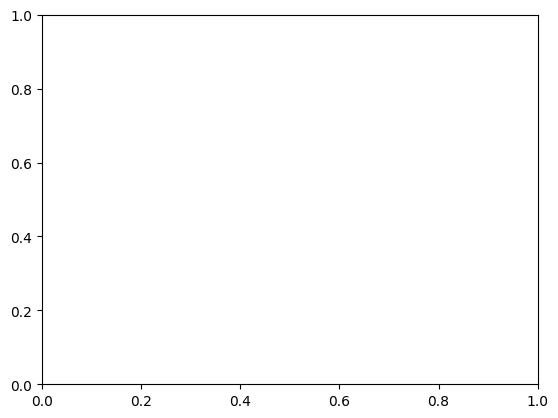

In [6]:
neighbors1 = NN_wrapper(train_sample1, positive_g_test)

# Extracting the types of object and their counts among the negative class:
types1, counts1 = np.unique(neighbors1[neighbors1['class'] == 'negative']['cdsxmatch'], return_counts=True)
types1_dict = dict(zip(types1, counts1))

sns.barplot(types1_dict, orient='h');

#### Train sample positive-negative ratio: 1-2

In [7]:
NN_wrapper(train_sample2, positive_g_test);

class
positive    1011
Name: count, dtype: int64

Percentage of positive class samples in the test set that have a positive class nearest neighbor: 100 %


#### Train sample positive-negative ratio: 1-3

In [8]:
NN_wrapper(train_sample3, positive_g_test);

class
positive    1011
Name: count, dtype: int64

Percentage of positive class samples in the test set that have a positive class nearest neighbor: 100 %


#### Train sample positive-negative ratio: 1-full

In [9]:
NN_wrapper(train_sample4, positive_g_test);

class
positive    1011
Name: count, dtype: int64

Percentage of positive class samples in the test set that have a positive class nearest neighbor: 100 %
